In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


1.12.1
0.12.1


In [2]:
import io
import os
import tarfile
import tempfile

import matplotlib.pyplot as plt
import requests
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")


100.0%
100.0%
100.0%


In [3]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [72]:
file = "/Users/fischer/Music/DDBY - Cafe de Touhou 1-8/2010 - Cafe de Touhou 1/2-faraway-country.flac"
metadata = torchaudio.info(file, format="FLAC")
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=13023820, num_channels=2, bits_per_sample=16, encoding=FLAC)


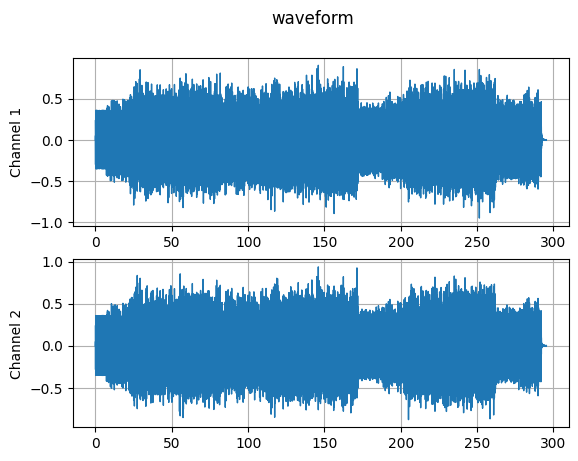

In [80]:
waveform, sample_rate = torchaudio.load(file)

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

plot_waveform(waveform, sample_rate)

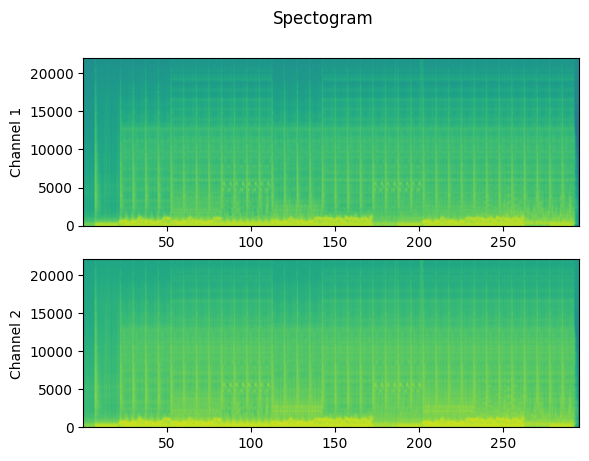

In [75]:
def plot_specgram(waveform, sample_rate, title="Spectogram"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

plot_specgram(waveform, sample_rate)

In [76]:
num_channels, num_frames = waveform.shape
new_waveform = waveform[:, :num_frames//2]

print(waveform.shape)
print(new_waveform.shape)

torch.Size([2, 13023820])
torch.Size([2, 6511910])


In [77]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

path1 = "default.flac"
torchaudio.save(path1, waveform, sample_rate)
inspect_file(path1)

path2 = "modified.flac"
torchaudio.save(path2, new_waveform, sample_rate)
inspect_file(path2)

----------
Source: default.flac
----------
 - File size: 31833181 bytes
 - AudioMetaData(sample_rate=44100, num_frames=13023820, num_channels=2, bits_per_sample=24, encoding=FLAC)

----------
Source: modified.flac
----------
 - File size: 15509230 bytes
 - AudioMetaData(sample_rate=44100, num_frames=6511910, num_channels=2, bits_per_sample=24, encoding=FLAC)



In [82]:
import math
import time

import librosa
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio, display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

DEFAULT_OFFSET = 201


def _get_log_freq(sample_rate, max_sweep_rate, offset):
    """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

    offset is used to avoid negative infinity `log(offset + x)`.

    """
    start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
    return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset


def _get_inverse_log_freq(freq, sample_rate, offset):
    """Find the time where the given frequency is given by _get_log_freq"""
    half = sample_rate // 2
    return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))


def _get_freq_ticks(sample_rate, offset, f_max):
    # Given the original sample rate used for generating the sweep,
    # find the x-axis value where the log-scale major frequency values fall in
    time, freq = [], []
    for exp in range(2, 5):
        for v in range(1, 10):
            f = v * 10**exp
            if f < sample_rate // 2:
                t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
                time.append(t)
                freq.append(f)
    t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
    time.append(t_max)
    freq.append(f_max)
    return time, freq


def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal


def plot_sweep(
    waveform,
    sample_rate,
    title,
    max_sweep_rate=48000,
    offset=DEFAULT_OFFSET,
):
    x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
    y_ticks = [1000, 5000, 10000, 20000, sample_rate // 2]

    time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
    freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
    freq_y = [f for f in freq if f in y_ticks and 1000 <= f <= sample_rate // 2]

    figure, axis = plt.subplots(1, 1)
    _, _, _, cax = axis.specgram(waveform[0].numpy(), Fs=sample_rate)
    plt.xticks(time, freq_x)
    plt.yticks(freq_y, freq_y)
    axis.set_xlabel("Original Signal Frequency (Hz, log scale)")
    axis.set_ylabel("Waveform Frequency (Hz)")
    axis.xaxis.grid(True, alpha=0.67)
    axis.yaxis.grid(True, alpha=0.67)
    figure.suptitle(f"{title} (sample rate: {sample_rate} Hz)")
    plt.colorbar(cax)
    plt.show(block=True)

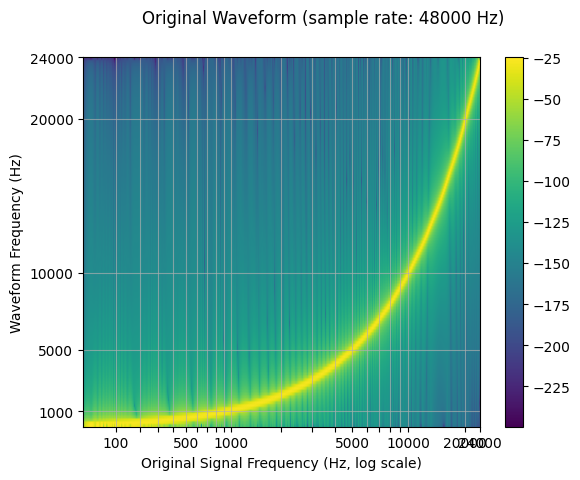

In [83]:
sample_rate = 48000
waveform = get_sine_sweep(sample_rate)

plot_sweep(waveform, sample_rate, title="Original Waveform")
Audio(waveform.numpy()[0], rate=sample_rate)

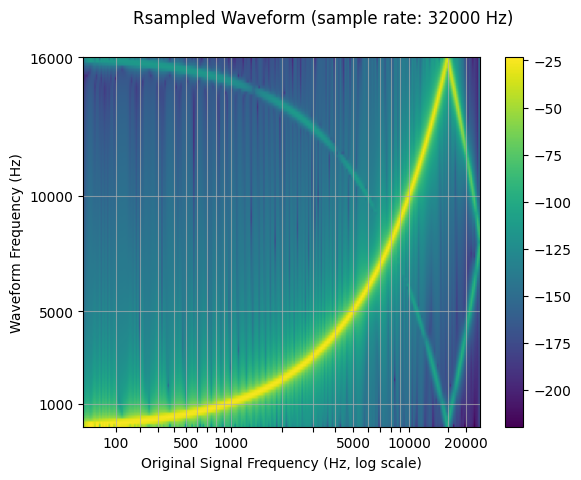

In [85]:
import torchaudio.transforms as T

resample_rate = 32000
resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)

plot_sweep(resampled_waveform, resample_rate, title="Rsampled Waveform")
Audio(resampled_waveform.numpy()[0], rate=resample_rate)

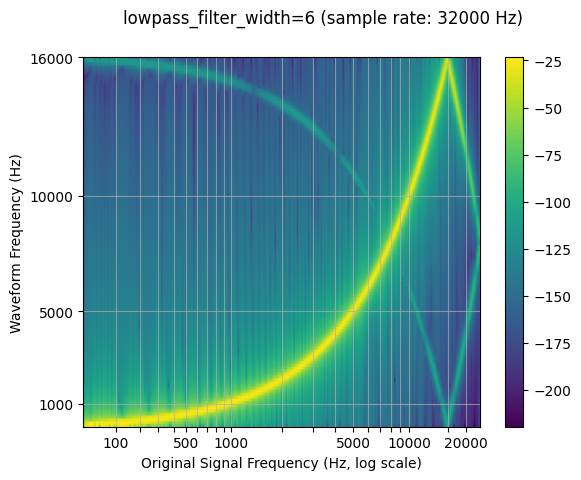

In [87]:
import torchaudio.functional as F

sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=6)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=6")

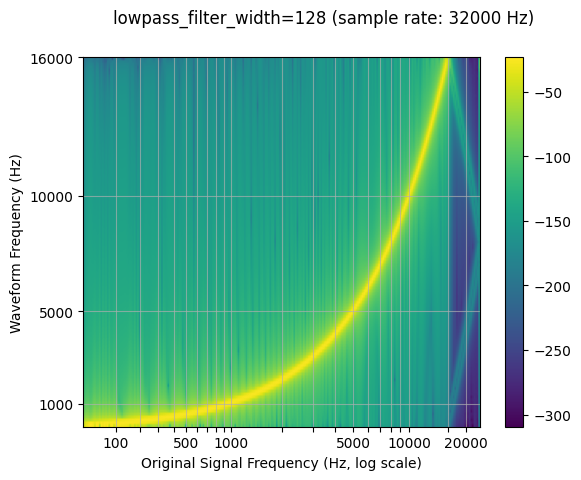

In [88]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=128)
plot_sweep(resampled_waveform, resample_rate, title="lowpass_filter_width=128")

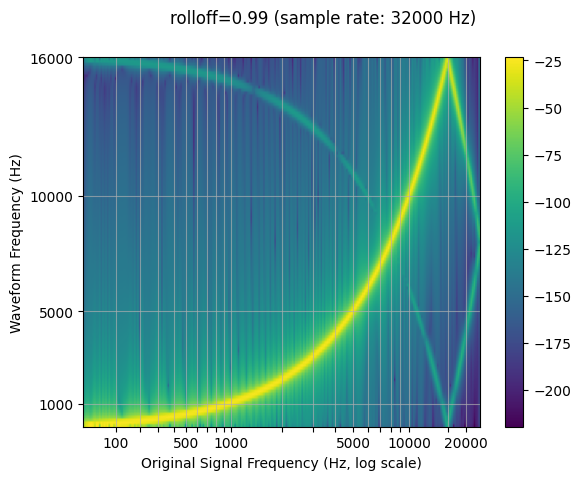

In [89]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

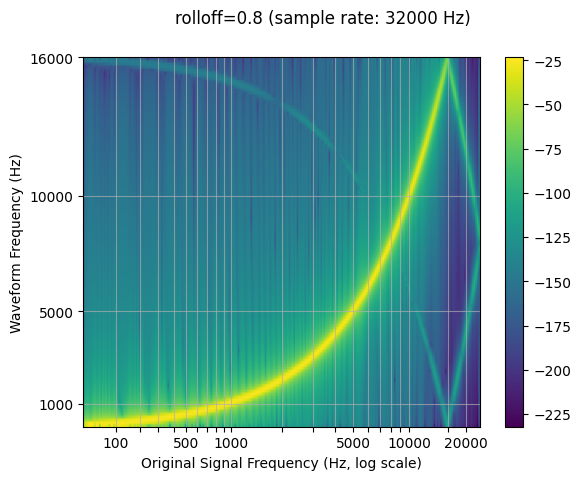

In [90]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

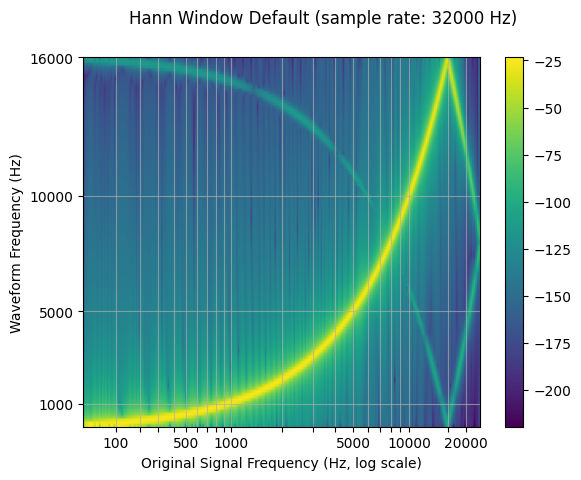

In [91]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")


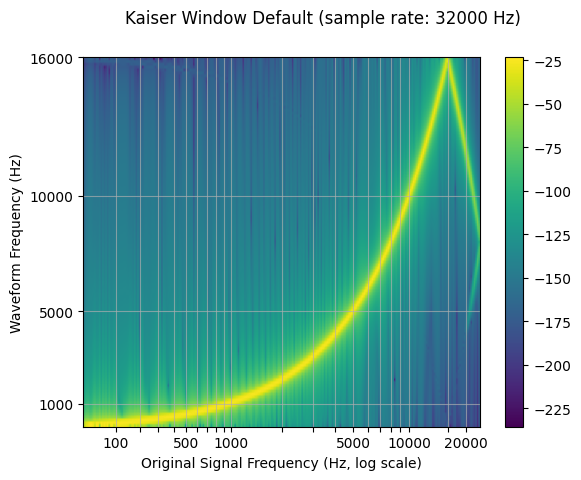

In [92]:
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

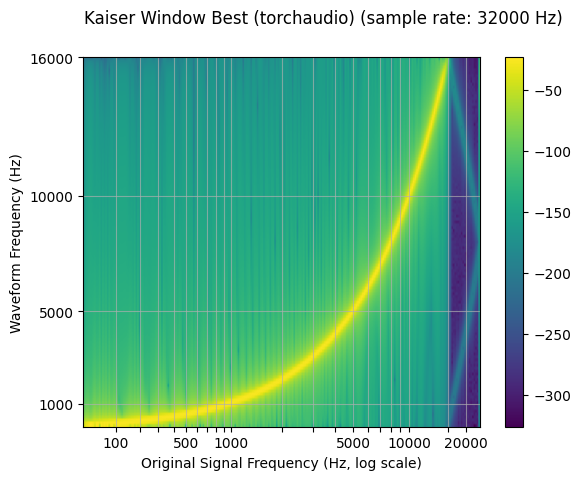

In [93]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

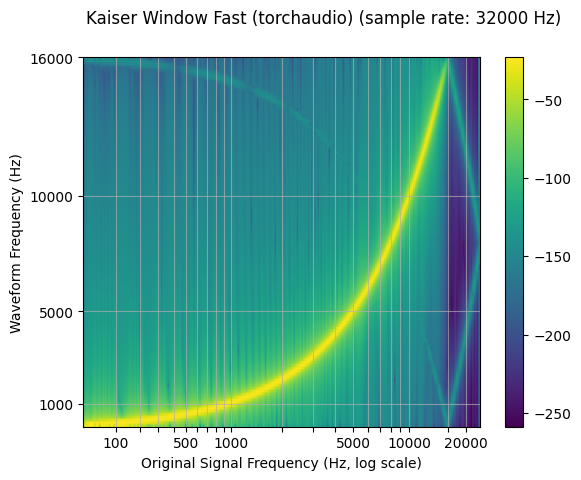

In [97]:
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386,
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

In [98]:
def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=6,
    rolloff=0.99,
    resampling_method="sinc_interpolation",
    beta=None,
    iters=5,
):
    if method == "functional":
        begin = time.monotonic()
        for _ in range(iters):
            F.resample(
                waveform,
                sample_rate,
                resample_rate,
                lowpass_filter_width=lowpass_filter_width,
                rolloff=rolloff,
                resampling_method=resampling_method,
            )
        elapsed = time.monotonic() - begin
        return elapsed / iters
    elif method == "transforms":
        resampler = T.Resample(
            sample_rate,
            resample_rate,
            lowpass_filter_width=lowpass_filter_width,
            rolloff=rolloff,
            resampling_method=resampling_method,
            dtype=waveform.dtype,
        )
        begin = time.monotonic()
        for _ in range(iters):
            resampler(waveform)
        elapsed = time.monotonic() - begin
        return elapsed / iters

In [107]:
configs = {
    "downsample (48 -> 44.1 kHz)": [48000, 44100],
    "downsample (16 -> 8 kHz)": [16000, 8000],
    "upsample (44.1 -> 48 kHz)": [44100, 48000],
    "upsample (8 -> 16 kHz)": [8000, 16000],
}

for label in configs:
    times, rows = [], []
    sample_rate = configs[label][0]
    resample_rate = configs[label][1]
    waveform = get_sine_sweep(sample_rate)

    # sinc 64 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=64)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 64)")

    # sinc 6 zero-crossings
    f_time = benchmark_resample("functional", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    t_time = benchmark_resample("transforms", waveform, sample_rate, resample_rate, lowpass_filter_width=16)
    times.append([None, 1000 * f_time, 1000 * t_time])
    rows.append("sinc (width 16)")

    # kaiser best
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=64,
        rolloff=0.9475937167399596,
        resampling_method="kaiser_window",
        beta=14.769656459379492,
    )
    times.append([1000 * f_time, 1000 * t_time])
    rows.append("kaiser_best")

    # kaiser fast
    f_time = benchmark_resample(
        "functional",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    t_time = benchmark_resample(
        "transforms",
        waveform,
        sample_rate,
        resample_rate,
        lowpass_filter_width=16,
        rolloff=0.85,
        resampling_method="kaiser_window",
        beta=8.555504641634386,
    )
    times.append([1000 * f_time, 1000 * t_time])
    rows.append("kaiser_fast")

    df = pd.DataFrame(times, columns=["functional", "transforms"], index=rows)
    df.columns = pd.MultiIndex.from_product([[f"{label} time (ms)"], df.columns])

    display(df.round(2))


downsample (48 -> 44.1 kHz) time (ms)                      
                                              librosa functional transforms
sinc (width 64)                                   NaN       5.66       0.33
sinc (width 16)                                   NaN       3.88       0.34
kaiser_best                                      6.35       0.36        NaN
kaiser_fast                                      5.51       0.24        NaN

downsample (16 -> 8 kHz) time (ms)                      
                                           librosa functional transforms
sinc (width 64)                                NaN       1.57       1.23
sinc (width 16)                                NaN       0.62       0.51
kaiser_best                                   1.82       1.33        NaN
kaiser_fast                                   0.56       0.63        NaN

upsample (44.1 -> 48 kHz) time (ms)                      
                                            librosa functional transforms
sinc (width 64)                                 NaN       4.27       0.33
sinc (width 16)                                 NaN       4.05       0.23
kaiser_best                                    6.18       0.26        NaN
kaiser_fast                                    5.51       0.22        NaN

upsample (8 -> 16 kHz) time (ms)                      
                                         librosa functional transforms
sinc (width 64)                              NaN       0.67       0.58
sinc (width 16)                              NaN       0.26       0.18
kaiser_best                                 0.37       0.19        NaN
kaiser_fast                                 0.29       0.19        NaN